In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [12]:
def vector_dsi(data, dirs):
    """Calculate the vector-sum DSI of `data` representing the responses to each direction in dirs
    (given in degrees). First, the x components (cosine) and y component (sine) vectors of vectors
    pointing from the origin to the angles in `dirs` are added. Then, the direction-selectivity index
    (DSI) is obtained from the normalized amplitude (between 0 and 1) of the vector made from the
    summed components. The angle that the vector-sum points gives the preferred angle (theta). 
    """
    out_shape = data.shape[1:]  # direction dimension will be lost
    data = data.reshape(data.shape[0], -1)  # flatten non-direction dims (e.g. conditions, cells, trials)
    rads = np.radians(dirs).reshape(-1, 1)  # degrees to radians and add second dimension to match data

    xsum = np.sum(data * np.cos(rads), axis=0)  # x vector
    ysum = np.sum(data * np.sin(rads), axis=0)  # y vector
    vec_norm = np.sqrt(xsum**2 + ysum**2)  # equivalent to: vec_norm = np.linalg.norm(xsums + ysums)
    dsi = np.squeeze(vec_norm / (np.sum(data, axis=0) + 0.000001))  # normalize magnitude of vector sum
    theta = np.squeeze(np.degrees(np.arctan2(ysum, xsum)))  # angle the vector sum is pointing in

    return dsi.reshape(out_shape), theta.reshape(out_shape)  # unflatten metrics


def scale_180_from_360(theta):
    """Wrap degrees from 360 scale to -180 -> 180 scale."""
    return (((theta - 180) % 360) - 180) if theta != 180 else 180


def polar(
    cell_trials,  # shape: (n_cells, n_trials, n_dirs)
    dirs,  # 1d array, shape: (n_dirs,)
    radius=None,
    cell_shadows=False,
    title=None,
    title_metrics=True,
    fig=None,
    ax=None,
    sub_loc=(1, 1, 1),
    dsi_tag_deg=-15.0,
    dsi_tag_mult=1.05,
    dsi_tag_fmt="dsi\n%.2f",
    avg_colour="black",
    avg_alpha=1.0,
    avg_linewidth=2,
    shadow_colour=None,
    shadow_alpha=0.25,
    shadow_linewidth=1.2,
):
    """Plot a polar plot of responses organized into a 3d dataset representing repeated trials for a
    set of cells. Vector-sums are drawn on a range of [0, 1], with DSI=1 being the outer radius of the
    plot."""
    # re-sort directions and make circular (closed, same start and end) for polar axes
    sort_idxs = dirs.argsort()
    circ_vals = cell_trials.transpose(2, 0, 1)[sort_idxs]
    circ_vals = np.concatenate(
        [circ_vals, np.expand_dims(circ_vals[0], axis=0)], axis=0
    )
    circle = np.radians(np.r_[dirs[sort_idxs], dirs[sort_idxs[0]]])

    peak = np.max(circ_vals)  # to set axis max

    avg_dsi, avg_theta = vector_dsi(cell_trials.sum(axis=(0, 1)), dirs)
    avg_theta = np.radians(avg_theta)

    # plot trials lighter
    if cell_shadows:
        shadows = np.mean(circ_vals, axis=2)
        dsis, thetas = vector_dsi(cell_trials.sum(axis=1).T, dirs)
    else:
        shadows = circ_vals.reshape(circle.size, -1)
        dsis, thetas = vector_dsi(cell_trials.reshape(-1, len(dirs)).T, dirs)

    thetas = np.radians(thetas)

    if fig is None and ax is None:
        fig = plt.figure(figsize=(5, 6))
        new_fig = True
    else:
        new_fig = False

    ax_exists = ax is not None
    ax = fig.add_subplot(*sub_loc, projection="polar") if not ax_exists else ax
    shadow_kwargs = {
        "color": avg_colour if shadow_colour is None else shadow_colour,
        "alpha": shadow_alpha,
        "linewidth": shadow_linewidth,
    }
    ax.plot(circle, shadows, **shadow_kwargs)
    ax.plot([thetas, thetas], [np.zeros_like(dsis), dsis * peak], **shadow_kwargs)

    # plot avg darker
    avg_kwargs = {"color": avg_colour, "alpha": avg_alpha, "linewidth": avg_linewidth}
    avg_spikes = np.mean(circ_vals.reshape(circle.size, -1), axis=1)
    ax.plot(circle, avg_spikes, **avg_kwargs)
    ax.plot([avg_theta, avg_theta], [0.0, avg_dsi * peak], **avg_kwargs)

    # misc settings
    radius = peak if radius is None else radius
    ax.set_rmax(radius)
    ax.set_rticks([radius])
    ax.set_rlabel_position(45)
    ax.set_thetagrids([0, 90, 180, 270])
    ax.set_xticklabels([])
    ax.tick_params(labelsize=15)
    if title_metrics:
        sub = "dsi = %.2f :: θ = %.2f\n  σ = %.2f :: σ = %.2f" % (
            avg_dsi,
            np.degrees(avg_theta),
            np.std(dsis),
            np.std(np.vectorize(scale_180_from_360)(np.degrees(thetas - avg_theta))),
        )
        title = sub if title is None else "%s\n%s" % (title, sub)
    else:
        deg = dsi_tag_deg + 20 if ax_exists else dsi_tag_deg  # HACK: ok for one overlay
        ax.text(
            np.radians(deg),
            radius * dsi_tag_mult,
            dsi_tag_fmt % avg_dsi,
            fontsize=13,
            c=avg_colour,
        )

    if title is not None:
        ax.set_title(title, size=15)

    if new_fig:
        return fig, ax
    else:
        return ax

In [15]:
max_response = 10
data = np.array([0.2, 0.6, 0.9, 1.0, 0.9, 0.6, 0.2, 0.05]) * max_response
dirs = np.array([225, 270, 315, 0, 45, 90, 135, 180])
dsi, theta = vector_dsi(data, dirs)
print("DSI: %.2f, theta: %.2f" % (dsi, theta))

DSI: 0.44, theta: -0.00


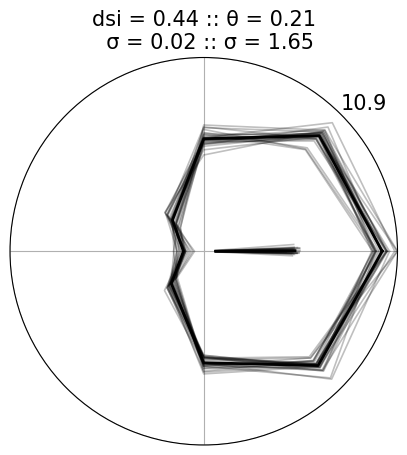

In [16]:
n_cells = 9
n_trials = 3

# generate fake multi-cell dataset
rng = np.random.default_rng()
mul_noise = rng.normal(loc=0, scale=0.05, size=(n_cells, n_trials, len(dirs))) + 1
flat_noise = rng.normal(loc=0, scale=0.03 * np.max(data), size=(n_cells, n_trials, len(dirs)))
cell_data = mul_noise * data.reshape(1, 1, -1) + flat_noise

polar_fig, polar_ax = polar(cell_data, dirs)